# Implementation of "On event based optical flow detection"

## Glossary:

### 1) Temporal filters

### 2) Spatial filters

### 3) Using filters on an image using combinations of both

In [348]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
# color map to plot
from matplotlib import cm
# processing files
import pandas as pd
# path.join, make directory
import os

import util

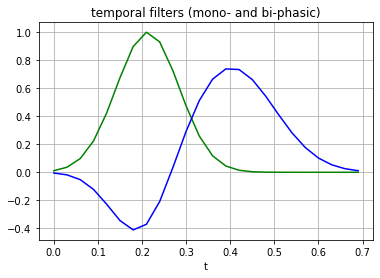

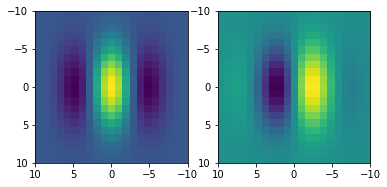

0.3713536063492956
-0.2477256867649551


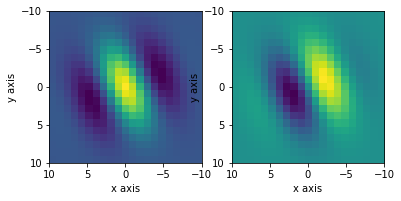

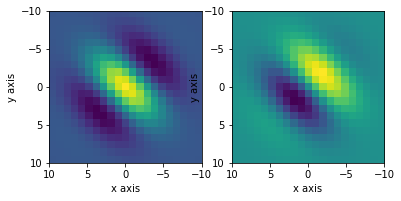

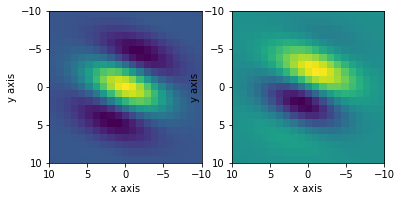

Total error=-1.734723475976807e-18
Error starts at indices from 9 to 11 with sum_err=-0.00930357096216684


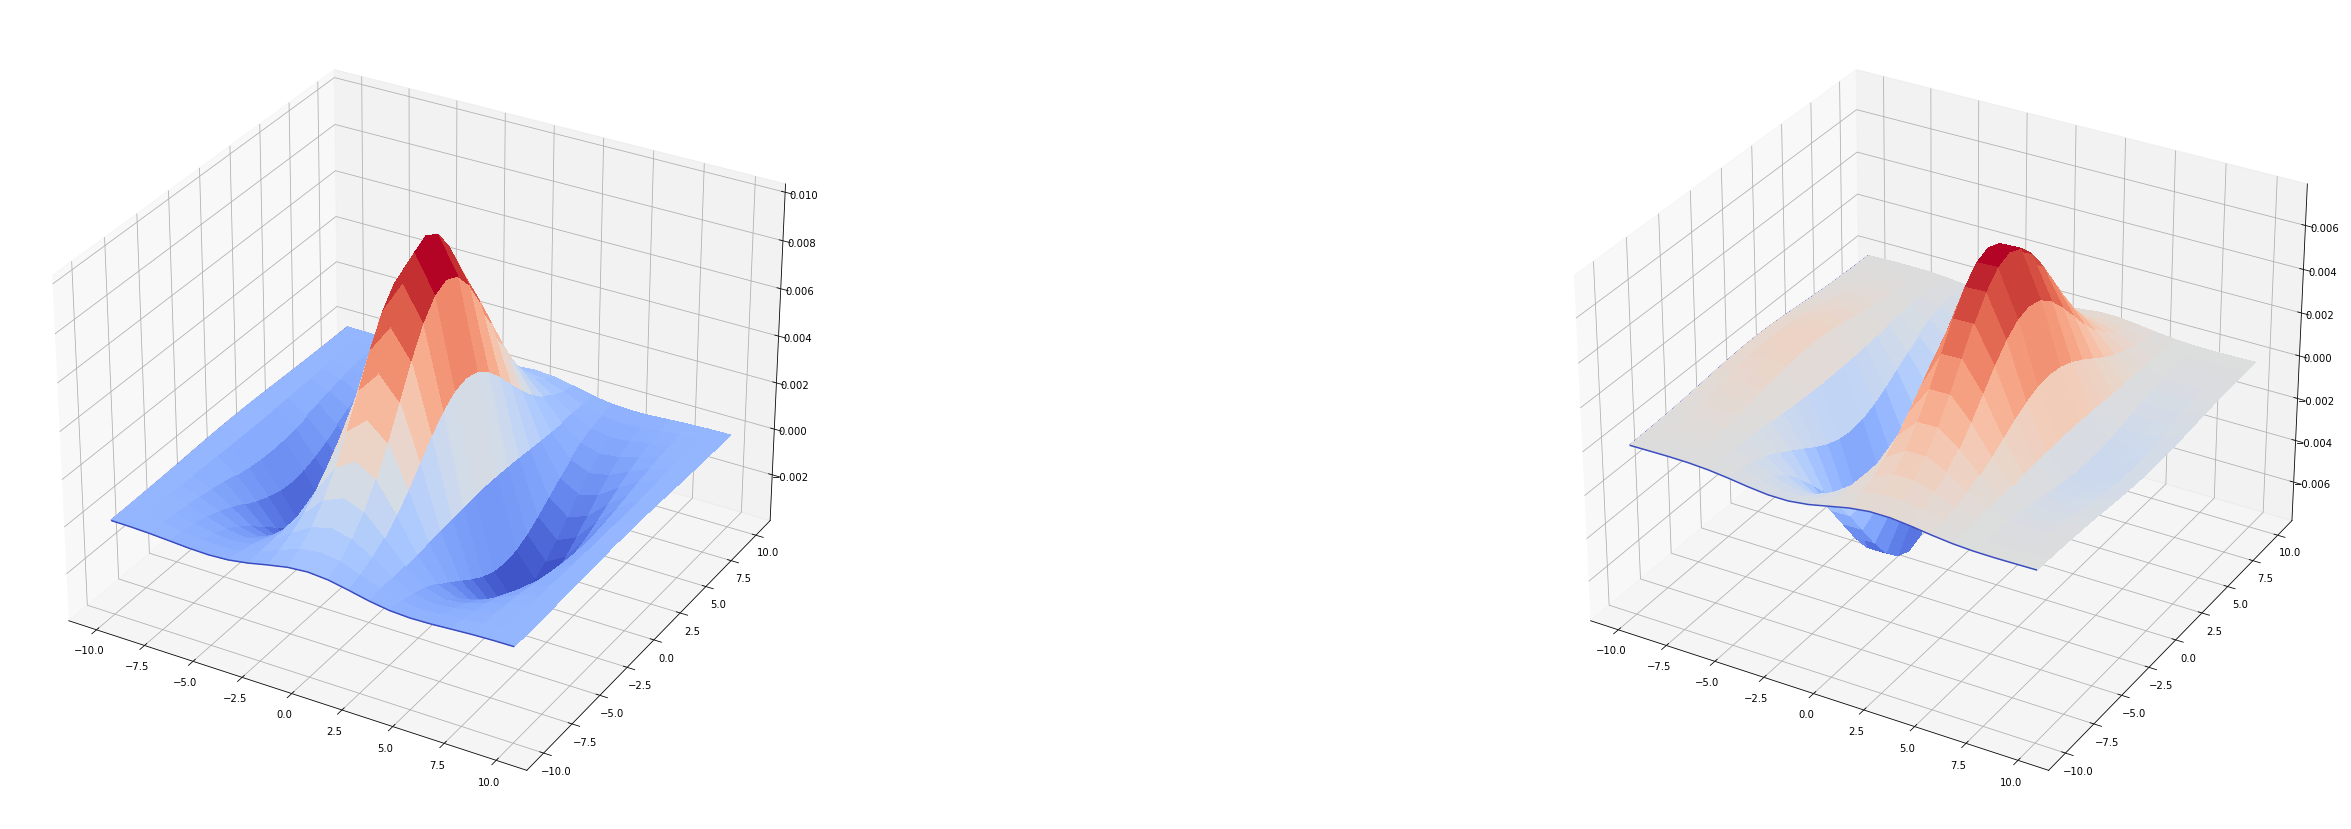

<Figure size 432x288 with 0 Axes>

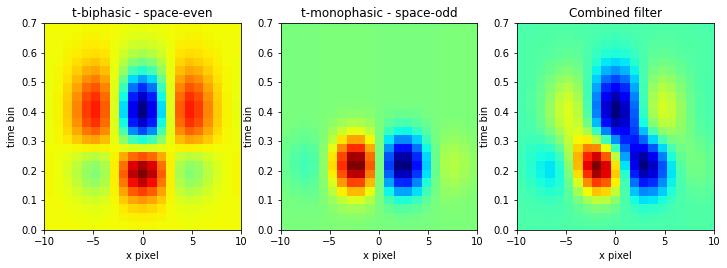

<Figure size 432x288 with 0 Axes>

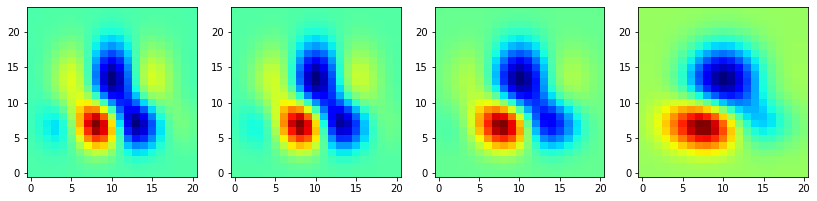

<Figure size 432x288 with 0 Axes>

In [349]:
%run filters_demonstrations.ipynb

## Implementation

### Hyperparameters

In [350]:
spatial_sigma = 25
default_filter_apothem = 10

f0x = 0.057
f0y = f0x

time_interval = 0.7
maximal_selective_velocity = 8

In [351]:
def load_events(path_to_events, nrows=None):
    # May add time to make it easier.
    event_list = pd.read_csv(path_to_events, delim_whitespace=True, header=None,
                          names=['t', 'x', 'y', 'p'],
                          dtype={'t': np.float64, 'x': np.int16, 'y': np.int16, 'p': np.int8},
                          engine='c', nrows=nrows, memory_map=True)
    # no polarity needed
    event_list = event_list.drop(columns=['p'])
    event_list = event_list.to_records(index=False)

    # First row: time, x, y
    time_start = event_list[0][0]
    time_end = event_list[len(event_list)-1][0]

    print("Loaded {:.2f}M events.".format(len(event_list) / 1e6))
    print("Time between: {} and {}.".format(time_start, time_end))
    
    return event_list

In [352]:
path_to_events = '../slider_far/events.txt'
event_list = load_events(path_to_events)

Loaded 3.44M events.
Time between: 0.0 and 6.399144.


### Set Parameters

These are the variables that are need to be set for image.

Possible options:

1) Scale the filter to the respond to velocity accurately. (Note: Scaling temporal filter is harder)

2) Artificially change the velocity to dilate the time frame to produce maximally selective results.

3) Using both is also possible, but is not tested.

(Note: spatial filters even/odd ratio doesn't scale, thus it needs further experimenting.

In [353]:
# Selected value
filter_amount = 4
# Dataset property
pixels_per_second = 100

no_scaling = False
scale_filter = not no_scaling and False
dilate_time = not no_scaling and True

if no_scaling:
    scale_amount = 1
    t_diff = 0.7

if scale_filter and not dilate_time:
    scale_amount = pixels_per_second / maximal_selective_velocity
    t_diff = 0.7

if not scale_filter and dilate_time:
    scale_amount = 1
    t_diff = time_interval / (pixels_per_second / maximal_selective_velocity)
    
if scale_filter and dilate_time:
    select_scale_first = False
    if select_scale_first:
        scale_amount = 2
        t_diff = time_interval / (pixels_per_second * filter_scale_amount / maximal_selective_velocity)
    else:
        t_diff = 0.2
        time_dilation = time_interval / t_diff
        scale_amount = pixels_per_second / (maximal_selective_velocity * time_dilation)

# Maximally selective for 8px/s
# pixels_per_second = 100

In [354]:
filter_apothem = math.ceil(scale_amount * default_filter_apothem)
filter_size = filter_apothem * 2 + 1

#### Create event subset suitable for the complete first response.

In [355]:
# Temporal filters become 0 when t_diff > 0.07
# So we can get a period that uses such
t_start = 0
event_subset, start_ind, stop_ind = util.get_event_subset(event_list, t_start, t_diff=t_diff, distribute_to_interval=True)
# event_subset, start_ind, stop_ind = util.get_event_subset(event_list, t_start)
# actual_t_end = t_start + t_diff
t_end = t_start + time_interval
print("Number of events: {}".format(stop_ind - start_ind))
print("Time interval: {} : {}".format(t_start, t_end))

Number of events: 13324
Time interval: 0 : 0.7


#### Set camera resolution and filter amount before processing.

In [356]:
# DAVIS camera pixel resolution
sensor_width = 240
sensor_height = 180

spatial_even_filters, spatial_odd_filters = \
    generate_spatial_filters(filter_amount, filter_apothem, 
                             default_filter_apothem, spatial_sigma, 
                             f0x, f0x)

#### Put the image through the filter to find filter outputs.

In [357]:
def get_filtered_image(event_subset, t_end,
                       start_x_img, start_y_img, stop_x_img, stop_y_img, 
                       filter_amount, temporal_mono_filter, 
                       temporal_bi1_filter, temporal_bi2_filter,
                       scale_biphasic1, scale_biphasic2,
                       spatial_even_filters, spatial_odd_filters
                      ):
       
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    stop_index = len(event_subset)
    # order is reversed for sensor_height - width for x, y indexing as in a picture
    image_phasic = np.zeros((2, pixels_y, pixels_x), dtype=np.float64)
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t

        # Start with even_filter's component, biphasic. Plus 0 is even
        image_phasic[0, y, x] += scale_biphasic1 * temporal_bi1_filter.get(t_diff) + \
            scale_biphasic2 * temporal_bi2_filter.get(t_diff)
        image_phasic[1, y, x] += temporal_mono_filter.get(t_diff)
    
    
    filtered_image = np.zeros((filter_amount, pixels_y, pixels_x), dtype=np.float64)

    for i in range(filter_amount):
        filtered_image[i] = cv2.filter2D(image_phasic[0], -1, spatial_even_filters[i], borderType=cv2.BORDER_CONSTANT)
        filtered_image[i] += cv2.filter2D(image_phasic[1], -1, spatial_odd_filters[i], borderType=cv2.BORDER_CONSTANT)        
        
    return filtered_image

In [358]:
%%time
filtered_image = get_filtered_image(event_subset, t_end,
                              0, 0, sensor_width, sensor_height,
                              filter_amount, temporal_mono_filter, 
                              temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2,
                              spatial_even_filters, spatial_odd_filters)

Wall time: 163 ms


#### Sum all filter responses into one image 

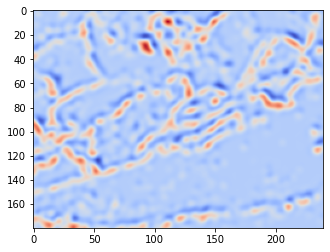

In [359]:
res = np.sum(filtered_image, axis=0)
plt.imshow(res, cmap=cm.coolwarm)
plt.savefig(os.path.join(output_dir, "res.png"))

#### Show individual filter responses.

<Figure size 432x288 with 0 Axes>

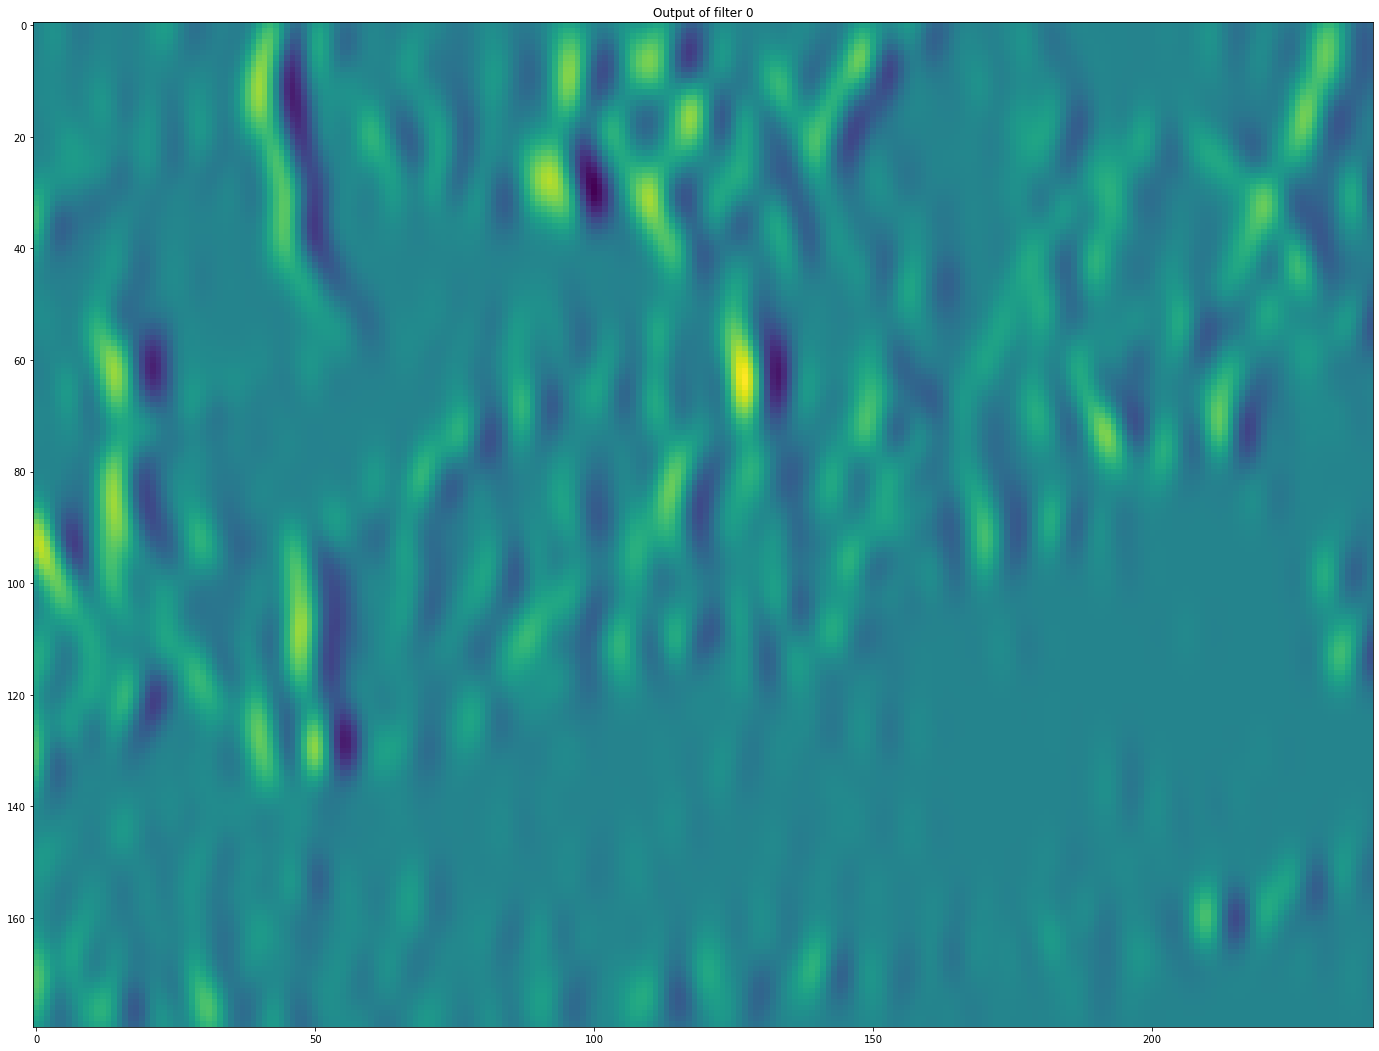

In [360]:
# Visualize results
fig = plt.figure()
plt.figure(figsize=(24, 24))

filters_to_show = filter_amount // 4

for i in range(filters_to_show):
    plt.subplot(1, filters_to_show, i+1)
    plt.imshow(filtered_image[i])
    plt.title("Output of filter " + str(i))

#### Vectorize the filter responses to output total response and direction.

In [361]:
def filter_vectors(filtered_image, filter_amount):
    # can also eigensum.
    pixels_y, pixels_x = filtered_image.shape[1:]
    u = np.zeros((pixels_y, pixels_x), dtype=np.float64)
    v = np.zeros((pixels_y, pixels_x), dtype=np.float64)
    for k in range(filter_amount):
        # there is no minus in sin, which I think is correct.
        # this is due to -theta in filter.
        u = u + np.cos(tau * k / filter_amount) * filtered_image[k]
        v = v + np.sin(tau * k / filter_amount) * filtered_image[k]
    return u, v

In [362]:
u, v = filter_vectors(filtered_image, filter_amount)

#### Show the responses with quivers.

In [363]:
def quiver_show_subset(u, v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop):
    u_subspace = u[y_subspace_start:y_subspace_stop, x_subspace_start:x_subspace_stop]
    v_subspace = v[y_subspace_start:y_subspace_stop, x_subspace_start:x_subspace_stop]
    
    x_subspace = np.arange(x_subspace_start, x_subspace_stop)
    y_subspace = np.arange(y_subspace_start, y_subspace_stop)
    x_subspace, y_subspace = np.meshgrid(x_subspace, y_subspace)
    
    fig = plt.figure(figsize=(24, 18))
    plt.gca().invert_yaxis()
    plt.xticks(np.arange(x_subspace_start, x_subspace_stop, 5))
    plt.yticks(np.arange(y_subspace_start, y_subspace_stop, 5))
    plt.quiver(x_subspace, y_subspace, u_subspace, v_subspace, color="r")

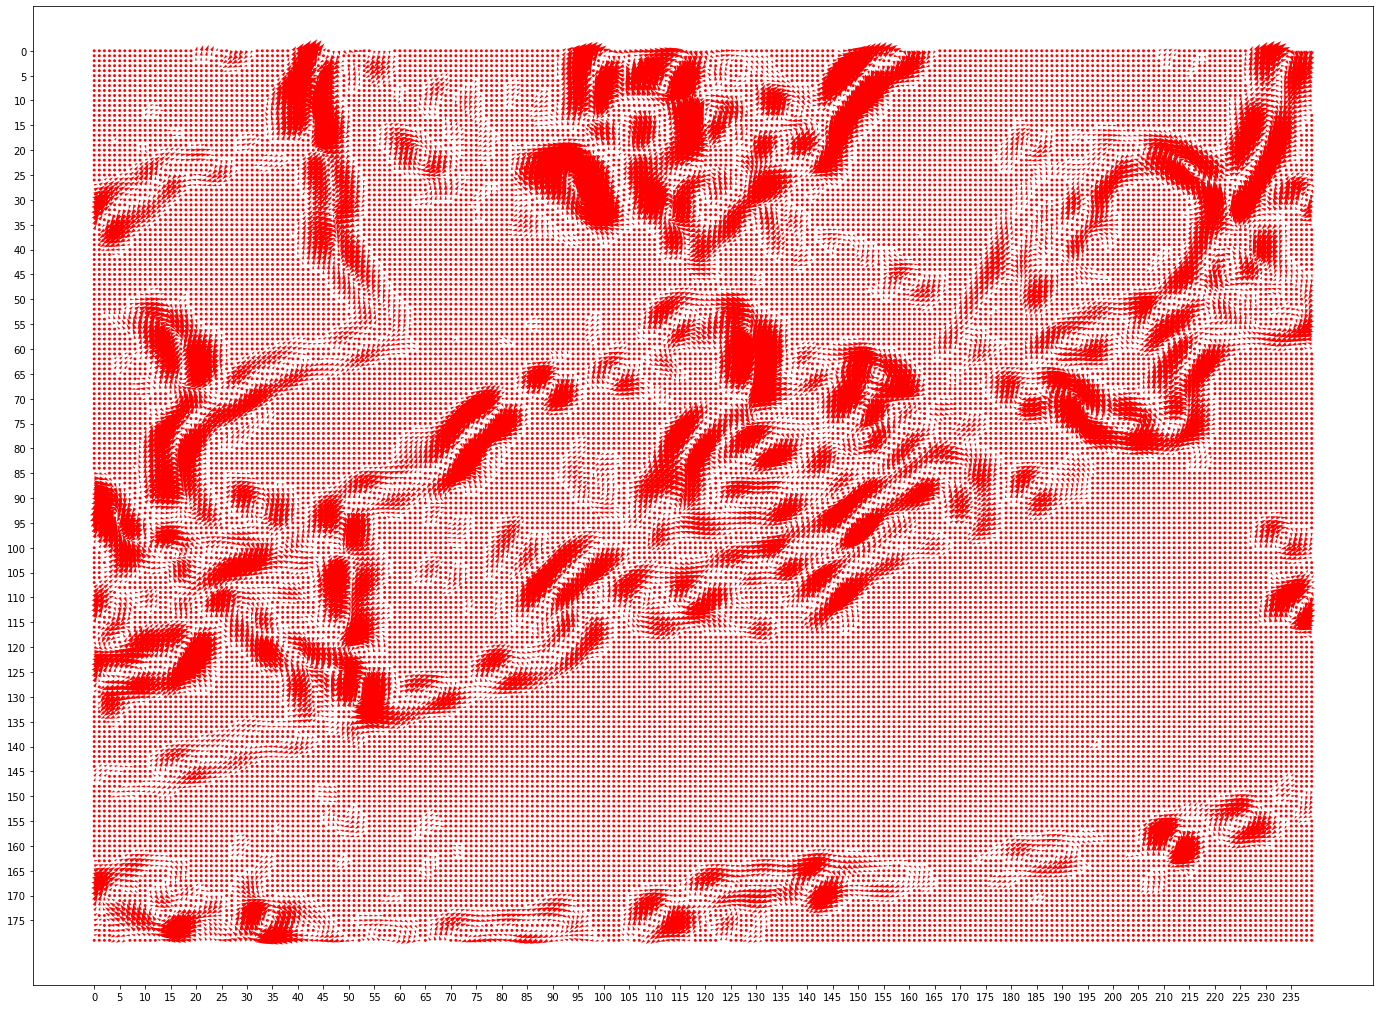

In [364]:
quiver_show_subset(u, v, 0, sensor_width, 0, sensor_height)
plt.savefig(os.path.join(output_dir, "whole_image.png"))
plt.show()

Look at the part of image mentioned below

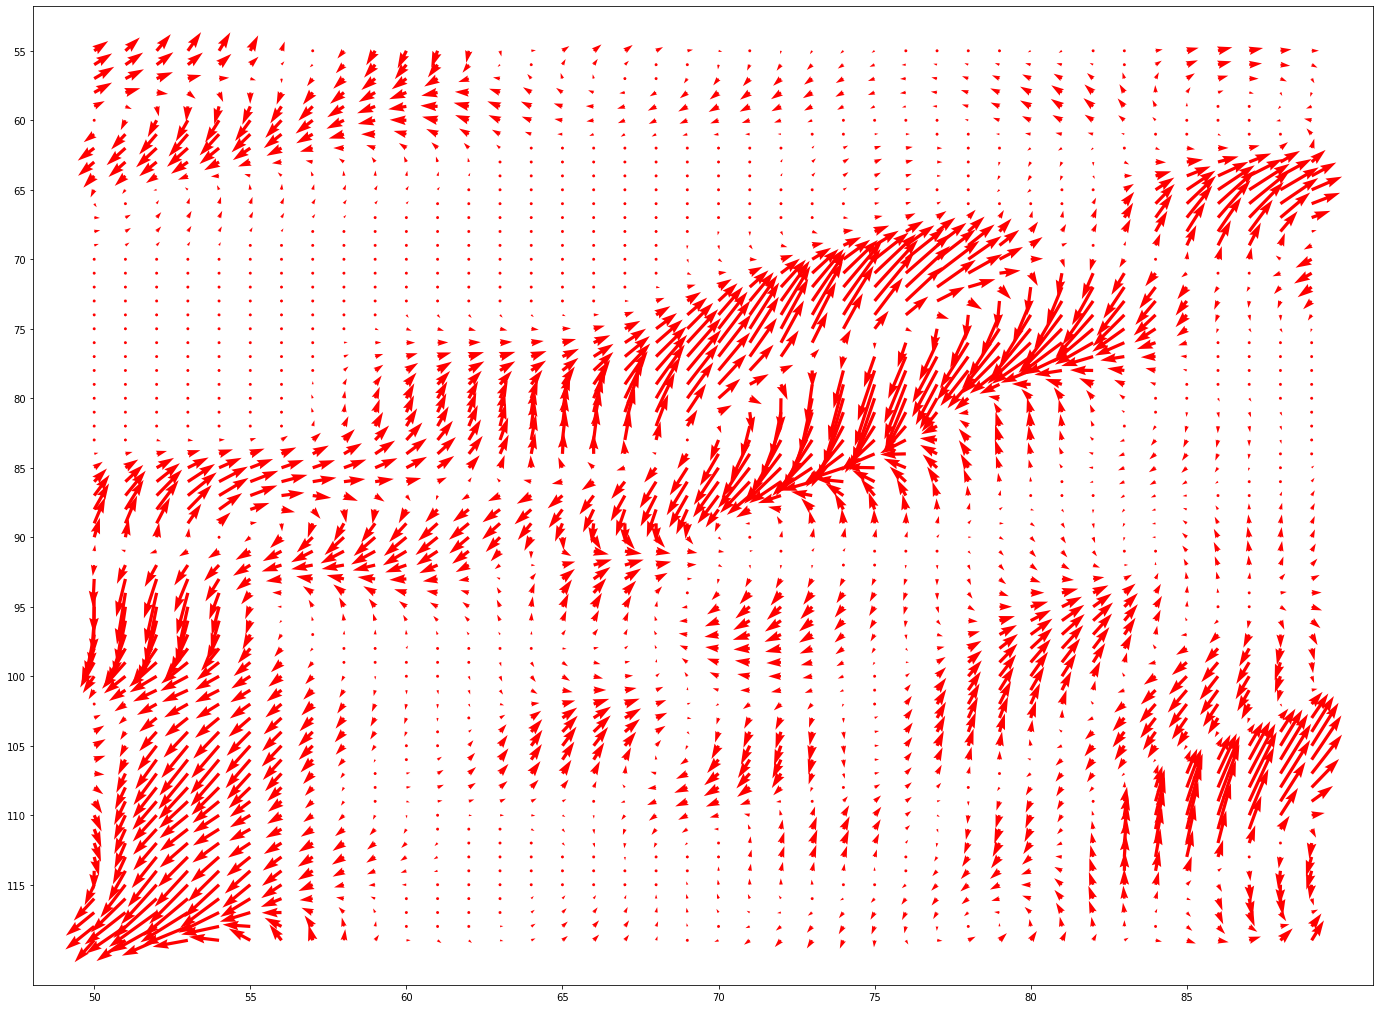

In [365]:
x_subspace_start = 50
x_subspace_stop = 90
y_subspace_start = 55
y_subspace_stop = 120

quiver_show_subset(u, v, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig(os.path.join(output_dir, "partial_image.png"))
plt.show()

In [366]:
give_basic_values(u, "u")

Mean u, to right: 0.02673724120502158
Mean u, to left: -0.02861858512048144
Amount u, to right: 22103
Amount u, to left: 21097
Sum u, total: -12.793047932204908
Amount deviation u, to right: 0.030914476050447146
Amount deviation u, to left: 0.03201433655115825


In [367]:
give_basic_values(v, "v")

Mean v, to right: 0.029490688302454278
Mean v, to left: -0.03011338176252119
Amount v, to right: 21680
Amount v, to left: 21519
Sum v, total: -8.651739750484952
Amount deviation v, to right: 0.03645109655795016
Amount deviation v, to left: 0.03769009881747312


### Normalize the image

In [368]:
def normalize_filters(filtered_image):
    beta_response = 1
    alpha_p = 0.1
    alpha_q = 0.002
    sigma_response = 3.6

    center = math.ceil(sigma_response * 3)
    size = center * 2 + 1

    filter_gaussian = cv2.getGaussianKernel(size, sigma_response)

    def relu(x):
        return x * (x > 0)
        
    filters_norm = np.empty(filtered_image.shape)
    q_response = np.zeros(filtered_image.shape[1:])
    for i in range(len(filtered_image)):
        q_response += cv2.filter2D(relu(filtered_image[i]), -1, filter_gaussian) / alpha_q
        
    q_response = np.sum(q_response)
    
    dividend = beta_response * filtered_image
    divisor = alpha_p + filtered_image + q_response
    filters_norm = dividend / divisor
        
    return filters_norm

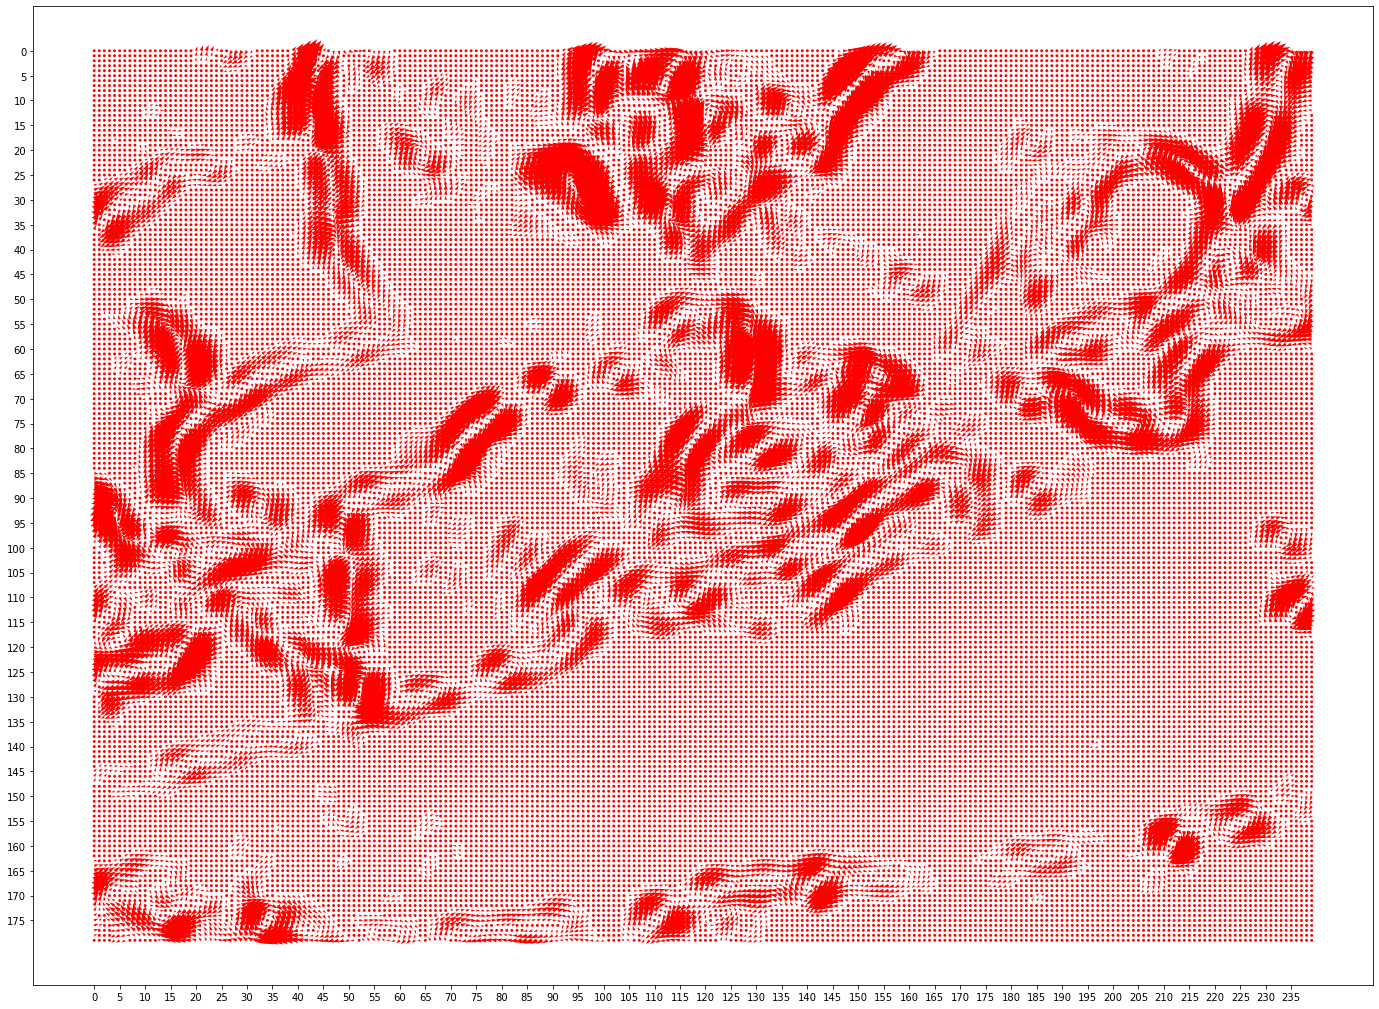

In [369]:
normalized_filters = normalize_filters(filtered_image)
u_normd, v_normd = filter_vectors(normalized_filters, filter_amount)

quiver_show_subset(u_normd, v_normd, 0, sensor_width, 0, sensor_height)

In [370]:
give_basic_values(u_normd)

Mean , to right: 2.4128696688955274e-08
Mean , to left: -2.58264922338314e-08
Amount , to right: 22103
Amount , to left: 21097
Sum , total: -1.154492374116256e-05
Amount deviation , to right: 2.789839108488902e-08
Amount deviation , to left: 2.8890946495612374e-08


In [371]:
give_basic_values(v_normd)

Mean , to right: 2.661351167039549e-08
Mean , to left: -2.717545255269292e-08
Amount , to right: 21680
Amount , to left: 21519
Sum , total: -7.807630467224839e-06
Amount deviation , to right: 3.2894847116413474e-08
Amount deviation , to left: 3.4012967167682653e-08


### See odd output and even output

Function for only calculating odd or even values (not both)

In [301]:
def get_filtered_image_even(event_subset, t_end,
                        start_x_img, start_y_img, stop_x_img, stop_y_img, 
                        filter_amount,
                        temporal_bi1_filter, temporal_bi2_filter,
                        scale_biphasic1, scale_biphasic2,
                        spatial_even_filters,
                      ):
       
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    stop_index = len(event_subset)
    # order is reversed for sensor_height - width for x, y indexing as in a picture
    image_phasic = np.zeros((pixels_y, pixels_x), dtype=np.float64)
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t
        
        image_phasic[y, x] += scale_biphasic1 * temporal_bi1_filter.get(t_diff) + \
            scale_biphasic2 * temporal_bi2_filter.get(t_diff)
    
    filtered_image = np.zeros((filter_amount, pixels_y, pixels_x), dtype=np.float64)

    for i in range(filter_amount):
        filtered_image[i] = cv2.filter2D(image_phasic, -1, spatial_even_filters[i], borderType=cv2.BORDER_CONSTANT)        
    
    return filtered_image

def get_filtered_image_odd(event_subset, t_end,
                       start_x_img, start_y_img, stop_x_img, stop_y_img, 
                       filter_amount, temporal_mono_filter, 
                       spatial_odd_filters
                      ):
       
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    stop_index = len(event_subset)
    # order is reversed for sensor_height - width for x, y indexing as in a picture
    image_phasic = np.zeros((pixels_y, pixels_x), dtype=np.float64)
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter
        t_diff = t_end - t

        image_phasic[y, x] += temporal_mono_filter.get(t_diff)
    
    filtered_image = np.zeros((filter_amount, pixels_y, pixels_x), dtype=np.float64)

    for i in range(filter_amount):
        filtered_image[i] = cv2.filter2D(image_phasic, -1, spatial_odd_filters[i], borderType=cv2.BORDER_CONSTANT)
        
    return filtered_image

In [302]:
even_image = get_filtered_image_even(event_subset, t_end,
                              0, 0, sensor_width, sensor_height,
                              filter_amount,
                              temporal_bi1_filter, temporal_bi2_filter,
                              scale_bi1, scale_bi2, spatial_even_filters)
odd_image = get_filtered_image_odd(event_subset, t_end,
                              0, 0, sensor_width, sensor_height,
                              filter_amount, temporal_mono_filter,
                              spatial_odd_filters)

u_odd, v_odd = filter_vectors(odd_image, filter_amount)
u_even, v_even = filter_vectors(even_image, filter_amount)

#### Look at the impact of odd / even filters

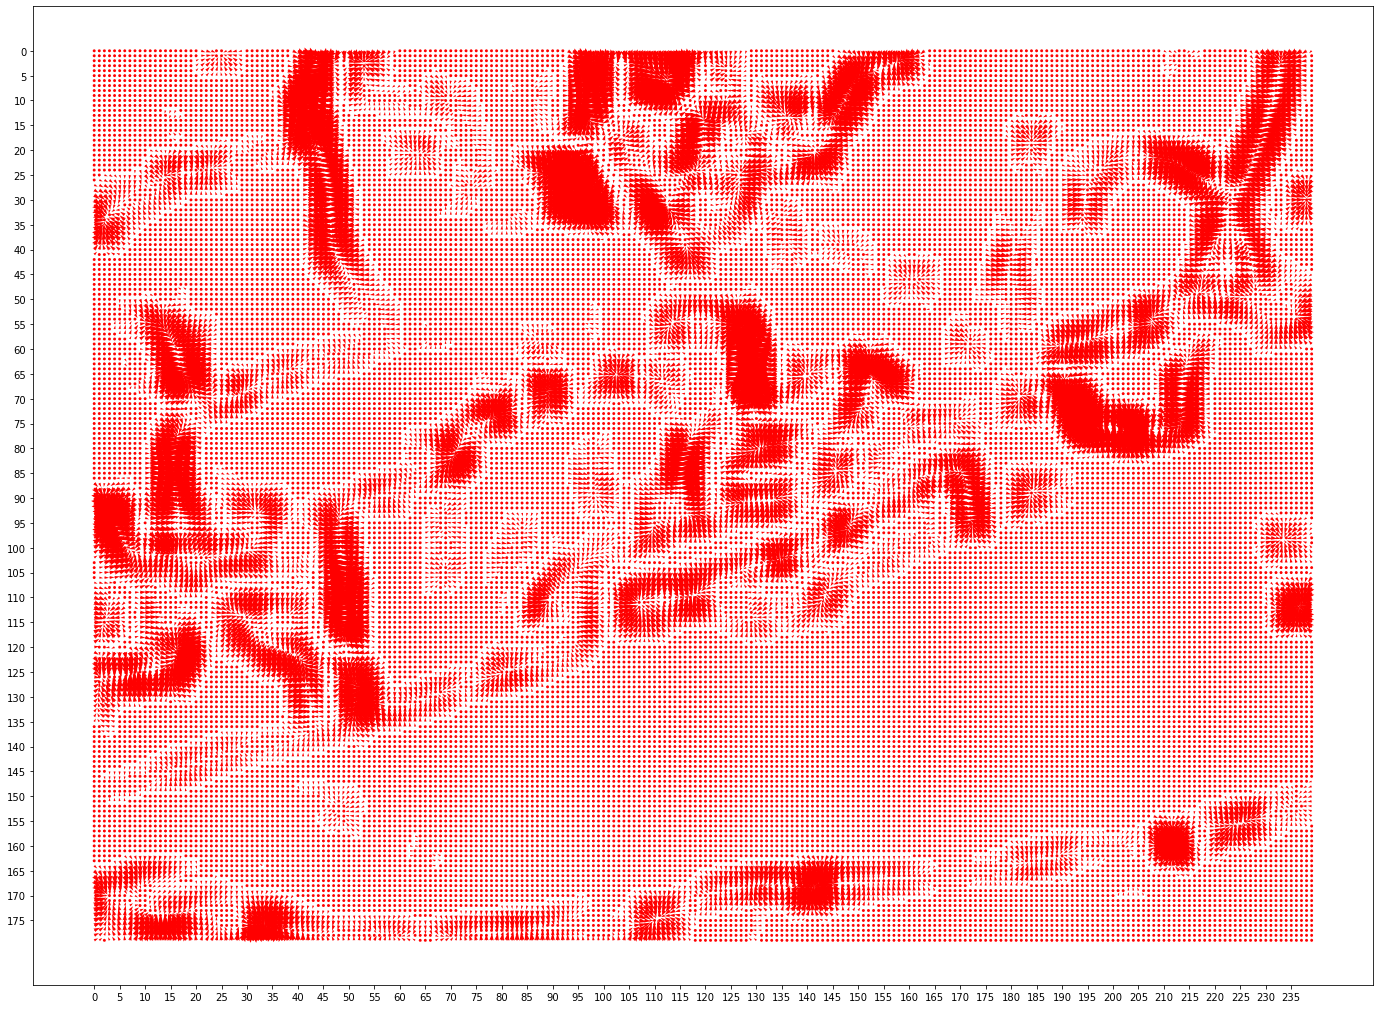

In [303]:
quiver_show_subset(u_odd, v_odd, 0, sensor_width, 0, sensor_height)
plt.savefig(os.path.join(output_dir, "odd_image.png"))
plt.show()

KeyboardInterrupt: 

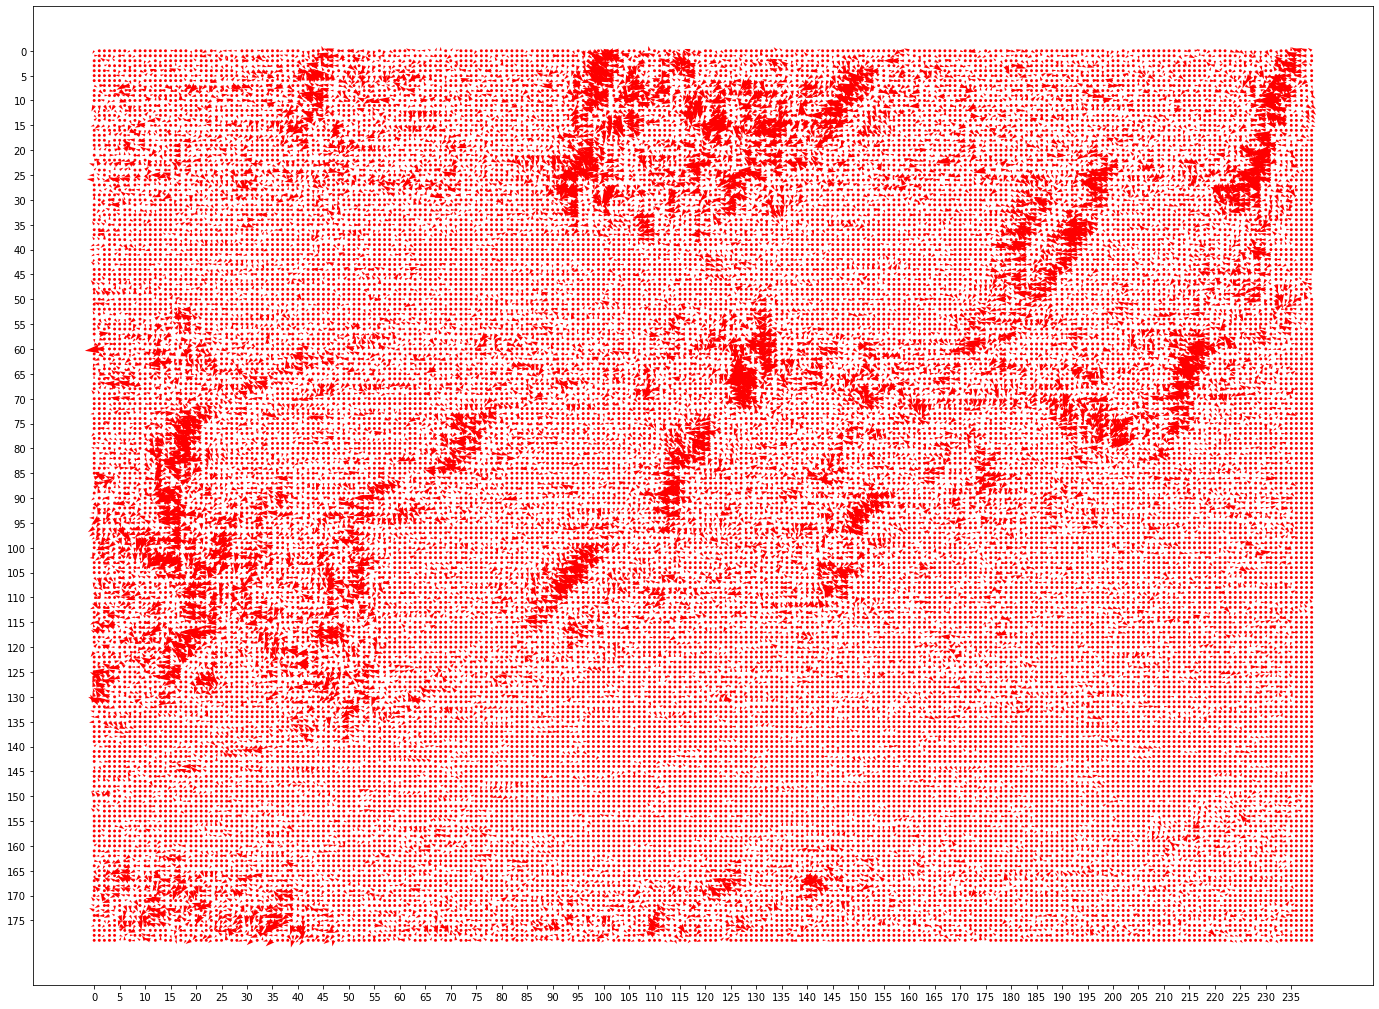

In [304]:
quiver_show_subset(u_even, v_even, 0, sensor_width, 0, sensor_height)
plt.savefig(os.path.join(output_dir, "even_image.png"))
plt.show()

In [ ]:
def give_basic_values(vector_array, identifier=""):
    print("Mean {}, to right: {}".format(identifier, np.mean(vector_array[vector_array > 0])))
    print("Mean {}, to left: {}".format(identifier, np.mean(vector_array[vector_array < 0])))
    print("Amount {}, to right: {}".format(identifier, np.sum(vector_array > 0)))
    print("Amount {}, to left: {}".format(identifier, np.sum(vector_array < 0)))
    print("Sum {}, total: {}".format(identifier, np.sum(vector_array)))
    print("Amount deviation {}, to right: {}".format(identifier, np.std(vector_array[vector_array > 0])))
    print("Amount deviation {}, to left: {}".format(identifier, np.std(vector_array[vector_array < 0])))
    
    return

In [ ]:
give_basic_values(u_odd, "odd")

In [ ]:
give_basic_values(u_even, "even")

In [ ]:
np.max(u_even)

In [ ]:
# no function to calculate
def frobenius_norm(u, v):
    total_amount = np.prod(u.shape) / 2
    norm = np.sqrt(np.sum(u ** 2 + v ** 2))
    
    u_normalized = u / norm
    v_normalized = v / norm
    
    return u_normalized, v_normalized

Normalize odd and even outputs

In [ ]:
u_odd_norm, v_odd_norm = frobenius_norm(u_odd, v_odd)
u_even_norm, v_even_norm = frobenius_norm(u_even, v_even)

In [ ]:
give_basic_values(u_odd_norm, "odd norm")

In [ ]:
give_basic_values(u_even_norm, "even norm")

In [ ]:
quiver_show_subset(u_odd_norm, v_odd_norm, 0, sensor_width, 0, sensor_height)
plt.savefig(os.path.join(output_dir, "odd_norm_image.png"))
plt.show()

In [ ]:
quiver_show_subset(u_even_norm, v_even_norm, 0, sensor_width, 0, sensor_height)
plt.savefig(os.path.join(output_dir, "even_norm_image.png"))
plt.show()

In [ ]:
u_sum_norm = u_even_norm + u_odd_norm
v_sum_norm = v_even_norm + v_odd_norm

quiver_show_subset(u_sum_norm , v_sum_norm, 0, sensor_width, 0, sensor_height)
plt.savefig(os.path.join(output_dir, "summation.png"))
plt.show()

In [ ]:
give_basic_values(u_sum_norm, "even norm")

### Run for [0.0, 0.7] to [5.7, 6.4], t_diff difference each. Check with filter_amount = 4 and filter_amount = 32

Turn off interactive mode of matplotplib. Look for directory.

In [ ]:
plt.ioff()

filters_4_directory = os.path.join(output_dir, "filters_4")
filters_32_directory = os.path.join(output_dir, "filters_32")
if not os.path.exists(filters_4_directory):
    os.mkdir(filters_4_directory)
if not os.path.exists(filters_32_directory):
    os.mkdir(filters_32_directory)    

Calculate the images, save them to folders.

In [ ]:
output_to_folder = False
calculate_one_image = True

t_start = event_list[0][0]
if calculate_one_image:
    t_amount = 1
else:
    t_amount = int(event_list[-1][0] // t_diff)

t_interval = 0.7

event_subset, start_inds, stop_inds = \
    util.get_event_indices(event_list, t_start, t_amount, t_diff, t_diff=t_diff, distribute_to_interval=True)

actual_t_start_range = t_start + np.arange(t_amount) * t_diff
actual_t_end_range = actual_t_start_range + t_diff

distributed_t_end_range = t_start + time_interval + np.arange(t_amount) * time_interval

# Initialize filters and outputs

spatial_even_filters_4, spatial_odd_filters_4 = generate_spatial_filters(
                            4, filter_apothem, 
                            default_filter_apothem, spatial_sigma, 
                            f0x, f0x)

spatial_even_filters_32, spatial_odd_filters_32 = generate_spatial_filters(
                            32, filter_apothem, 
                            default_filter_apothem, spatial_sigma, 
                            f0x, f0x)

u_list_filter_4 = np.empty((t_amount, sensor_height, sensor_width))
v_list_filter_4 = np.empty((t_amount, sensor_height, sensor_width))

u_list_filter_32 = np.empty((t_amount, sensor_height, sensor_width))
v_list_filter_32 = np.empty((t_amount, sensor_height, sensor_width))

for index in range(t_amount):
    start_ind = start_inds[index] - start_inds[0]
    stop_ind = stop_inds[index] - start_inds[0]
    event_subset_time = event_subset[start_ind:stop_ind]
    filter_amount = 4
    filtered_image_4 = get_filtered_image(event_subset_time, distributed_t_end_range[index],
                                  0, 0, sensor_width, sensor_height,
                                  filter_amount, temporal_mono_filter, 
                                  temporal_bi1_filter, temporal_bi2_filter,
                                  scale_bi1, scale_bi2,
                                  spatial_even_filters_4, spatial_odd_filters_4)
    u_list_filter_4[index], v_list_filter_4[index] = filter_vectors(filtered_image_4, filter_amount)
    if output_to_folder:
        quiver_show_subset(u_list_filter_4[index], v_list_filter_4[index], 0, sensor_width, 0, sensor_height)
        file_name = "{:.2f}_to_{:.2f}.png".format(actual_t_start_range[index], actual_t_end_range[index])
        plt.savefig(os.path.join(output_dir, "filters_32", file_name))
        plt.close()

    filter_amount = 32
    filtered_image_32 = get_filtered_image(event_subset_time, distributed_t_end_range[index],
                                  0, 0, sensor_width, sensor_height,
                                  filter_amount, temporal_mono_filter, 
                                  temporal_bi1_filter, temporal_bi2_filter,
                                  scale_bi1, scale_bi2,
                                  spatial_even_filters_32, spatial_odd_filters_32)
    u_list_filter_32[index], v_list_filter_32[index] = filter_vectors(filtered_image_32, filter_amount)
#     u_diff, v_diff = u_list_filter[32] - u_list_filter[4], v_list_filter[32] - v_list_filter[4]
    if output_to_folder:
        quiver_show_subset(u_list_filter_32[index], v_list_filter_32[index], 0, sensor_width, 0, sensor_height)
        file_name = "{:.2f}_to_{:.2f}.png".format(actual_t_start_range[index], actual_t_end_range[index])
        plt.savefig(os.path.join(output_dir, "filters_4", file_name))
        plt.close()

In [ ]:
# no function to calculate
def frobenius_norm(u, v):
    total_amount = np.prod(u.shape) / 2
    norm = np.sqrt(np.sum(u ** 2 + v ** 2)) / total_amount
    
    u_normalized = u / norm
    v_normalized = v / norm
    
    return u_normalized, v_normalized

In [ ]:
u_4 = u_list_filter_4[0]
u_32 = u_list_filter_32[0]
v_4 = v_list_filter_4[0]
v_32 = v_list_filter_32[0]

In [ ]:
print(np.sum(u_4[u_4>0]))
print(np.sum(v_4[v_4>0]))

In [ ]:
print(np.sum(u_32[u_32>0]))
print(np.sum(v_32[v_32>0]))

In [ ]:
u_norm_4, v_norm_4 = frobenius_norm(u_4, v_4)
u_norm_32, v_norm_32 = frobenius_norm(u_32, v_32)

In [ ]:
print(np.sum(u_norm_4))

In [ ]:
quiver_show_subset(u_norm_4, v_norm_4, 0, sensor_width, 0, sensor_height)
quiver_show_subset(u_norm_32, v_norm_32, 0, sensor_width, 0, sensor_height)

In [ ]:
quiver_show_subset(u_norm_32-u_norm_4, v_norm_32-v_norm_4, 0, sensor_width, 0, sensor_height)

#### Print properties for values over x-axis

In [ ]:
give_basic_values(u_norm_4)

Calculate left side difference

#### Check for u, v values to filter amount scaling

In [ ]:
raise RuntimeError("Break")

In [ ]:
filter_amount = 32

filtered_images = np.empty((t_amount, filter_amount, sensor_height, sensor_width))

spatial_even_filters, spatial_odd_filters = generate_spatial_filters(
                            filter_amount, filter_apothem, 
                            default_filter_apothem, spatial_sigma, 
                            f0x, f0x)

In [ ]:
for index in range(t_amount):
    start_ind = start_inds[index] - start_inds[0]
    stop_ind = stop_inds[index] - start_inds[0]
    event_subset_time = event_subset[start_ind:stop_ind]
    filtered_images[index] = get_filtered_image(event_subset_time, distributed_t_end_range[index],
                                  0, 0, sensor_width, sensor_height,
                                  filter_amount, temporal_mono_filter, 
                                  temporal_bi1_filter, temporal_bi2_filter,
                                  scale_bi1, scale_bi2,
                                  spatial_even_filters, spatial_odd_filters)
    u, v = filter_vectors(filtered_images[index], filter_amount)
    quiver_show_subset(u, v, 0, sensor_width, 0, sensor_height)
    file_name = "{:.2f}_to_{:.2f}.png".format(actual_t_start_range[index], actual_t_end_range[index])
    plt.savefig(os.path.join(output_dir, "filters_32", file_name))
    plt.close()

### Looking at spatial odd and spatial even figures

In [ ]:
# put interactive mode on
plt.ion()

In [ ]:
u_4 = u_list_filter_4[0]
u_32 = u_list_filter_32[0]
v_4 = v_list_filter_4[0]
v_32 = v_list_filter_32[0]

In [ ]:
print(np.sum(u_4[u_4>0]))
print(np.sum(v_4[v_4>0]))

In [ ]:
print(np.sum(u_32[u_32>0]))
print(np.sum(v_32[v_32>0]))

In [ ]:
u_norm_4, v_norm_4 = frobenius_norm(u_4, v_4)
u_norm_32, v_norm_32 = frobenius_norm(u_32, v_32)

In [ ]:
print(np.sum(u_norm_4))

In [ ]:
quiver_show_subset(u_norm_4, v_norm_4, 0, sensor_width, 0, sensor_height)
quiver_show_subset(u_norm_32, v_norm_32, 0, sensor_width, 0, sensor_height)

In [ ]:
quiver_show_subset(u_norm_32-u_norm_4, v_norm_32-v_norm_4, 0, sensor_width, 0, sensor_height)

#### Print properties for values over x-axis

In [ ]:
print("Mean 4, to right: {}".format(np.mean(u_norm_4[u_norm_4 > 0])))
print("Mean 4, to left: {}".format(np.mean(u_norm_4[u_norm_4 < 0])))
print("Sum 4, to right: {}".format(np.sum(u_norm_4 > 0)))
print("Sum 4, to left: {}".format(np.sum(u_norm_4 < 0)))
print("Sum 4, total: {}".format(np.sum(u_norm_4)))
print("Standard deviation 4, to right: {}".format(np.std(u_norm_4[u_norm_4 > 0])))
print("Standard deviation 4, to left: {}".format(np.std(u_norm_4[u_norm_4 < 0])))

Calculate left side difference

In [ ]:
u_wide = u_norm_4 * (np.abs(u_norm_4)>np.abs(np.max(u_norm_4)))
v_wide = np.zeros(u_wide.shape)

In [ ]:
quiver_show_subset(u_stab_4, v_wide, 0, sensor_width, 0, sensor_height)

Function for only calculating odd or even values (not both)

In [ ]:
def get_filtered_image_odd_even(event_subset, t_end,
                        start_x_img, start_y_img, stop_x_img, stop_y_img, 
                        filter_amount, temporal_mono_filter, 
                        temporal_bi1_filter, temporal_bi2_filter,
                        scale_biphasic1, scale_biphasic2,
                        spatial_even_filters, spatial_odd_filters,
                        is_odd
                      ):
       
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    stop_index = len(event_subset)
    # order is reversed for sensor_height - width for x, y indexing as in a picture
    image_phasic = np.zeros((pixels_y, pixels_x), dtype=np.float64)
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t

        if is_odd:
            image_phasic[y, x] += scale_biphasic1 * temporal_bi1_filter.get(t_diff) + \
                scale_biphasic2 * temporal_bi2_filter.get(t_diff)
        else:
            image_phasic[y, x] += temporal_mono_filter.get(t_diff)
    
    
    filtered_image = np.zeros((filter_amount, pixels_y, pixels_x), dtype=np.float64)

    for i in range(filter_amount):
        if is_odd:
            filtered_image[i] += cv2.filter2D(image_phasic, -1, spatial_odd_filters[i], borderType=cv2.BORDER_CONSTANT)        
        else:
            filtered_image[i] += cv2.filter2D(image_phasic, -1, spatial_even_filters[i], borderType=cv2.BORDER_CONSTANT)
            
    return filtered_image

In [ ]:
raise RuntimeError("Break")

#### Whole image over time.

In [ ]:
u_total = np.sum(u_list, axis=0)
v_total = np.sum(v_list, axis=0)

quiver_show_subset(u_total, v_total, 0, sensor_width, 0, sensor_height)
plt.savefig(os.path.join(output_dir, "whole_image_over_time.png"))

#### Partial image over time.

In [ ]:
quiver_show_subset(u_total, v_total, x_subspace_start, x_subspace_stop, y_subspace_start, y_subspace_stop)
plt.savefig(os.path.join(output_dir, "partial_image_over_time.png"))

#### Normalization.

##### Note: Doesn't work.

In [ ]:
# no function to calculate
def frobenius_norm(u, v):
    total_amount = np.prod(u.shape) / 2
    norm = np.sqrt(np.sum(u ** 2 + v ** 2)) / total_amount
    
    u_normalized = u / norm
    v_normalized = v / norm
    
    return u_normalized, v_normalized

In [ ]:
raise RuntimeError("Normalization doesn't work")

In [ ]:
u_stab_4 = u_norm_4 - np.mean(u_norm_4[u_norm_4 > 0])

In [ ]:
u_stab_4 = u_norm_4 * (u_norm_4 < 0)

In [ ]:
def normalize(u, v):
    beta_response = 1
    alpha_p = 0.1
    alpha_q = 0.002
    sigma_response = 3.6

    center = math.ceil(sigma_response * 3)
    size = center * 2 + 1

    filter_gaussian = cv2.getGaussianKernel(size, sigma_response)

    def relu(x):
        return x * (x > 0)

    uv_response = np.sqrt(u**2 + v**2)
    print(np.sum(uv_response==0))
    gaussian_response = cv2.filter2D(uv_response, -1, filter_gaussian)
    normalized_response = beta_response * uv_response / (alpha_p + uv_response + relu(gaussian_response / alpha_q))
    
    ratio = normalized_response / uv_response
    u_normalized = ratio * u
    v_normalized = ratio * v
    
    return u_normalized, v_normalized

In [ ]:
u_normalized, v_normalized = normalize(u, v)

In [ ]:
quiver_show_subset(u_normalized, v_normalized, 0, sensor_width, 0, sensor_height)
plt.savefig("whole_image_normalized.png")

In [ ]:
def normalize(u, v):
    beta_response = 1
    alpha_p = 0.1
    alpha_q = 0.002
    sigma_response = 3.6

    center = math.ceil(sigma_response * 3)
    size = center * 2 + 1

    filter_gaussian = cv2.getGaussianKernel(size, sigma_response)

    def relu(x):
        return x * (x > 0)

    uv_response = np.sqrt(u**2 + v**2)
    
    gaussian_response = cv2.filter2D(uv_response, -1, filter_gaussian)
    normalized_response = beta_response * uv_response / (alpha_p + uv_response + relu(gaussian_response / alpha_q))
    
    ratio = normalized_response / uv_response
    u_normalized = ratio * u
    v_normalized = ratio * v
    
    return u_normalized, v_normalized

# Issues

* Combining response timeframes without normalization seems to be not effective.
* Gaussian time filters should be scalable.

In [ ]:
def get_odd_filtered_image(event_subset, t_end,
                       start_x_img, start_y_img, stop_x_img, stop_y_img, 
                       filter_amount, temporal_mono_filter, 
                       temporal_bi1_filter, temporal_bi2_filter,
                       scale_biphasic1, scale_biphasic2,
                       spatial_even_filters, spatial_odd_filters
                      ):
       
    pixels_x = stop_x_img - start_x_img
    pixels_y = stop_y_img - start_y_img
    
    stop_index = len(event_subset)
    # order is reversed for sensor_height - width for x, y indexing as in a picture
    image_phasic = np.zeros((2, pixels_y, pixels_x), dtype=np.float64)
    
    for index in np.arange(0, stop_index):
        t, x, y = event_subset[index]

        # Compute temporal filter

        t_diff = t_end - t

        # Start with even_filter's component, biphasic. Plus 0 is even
#         image_phasic[0, y, x] += scale_biphasic1 * temporal_bi1_filter.get(t_diff) + \
#             scale_biphasic2 * temporal_bi2_filter.get(t_diff)
        image_phasic[1, y, x] += temporal_mono_filter.get(t_diff)
    
    
    filtered_image = np.zeros((filter_amount, pixels_y, pixels_x), dtype=np.float64)

    for i in range(filter_amount):
#         filtered_image[i] = cv2.filter2D(image_phasic[0], -1, spatial_even_filters[i], borderType=cv2.BORDER_CONSTANT)
        filtered_image[i] += cv2.filter2D(image_phasic[1], -1, spatial_odd_filters[i], borderType=cv2.BORDER_CONSTANT)        
        
    return filtered_image